In [1]:
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))

from sklearn.externals import joblib
from aye import *
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
# Reader
reader = DataReader(rel_dir='images', ext='jpg')

# Detector
clf = joblib.load('../model/svc.pkl')
scaler = joblib.load('../model/scaler.pkl')
detector = FruitDetector(clf, scaler)

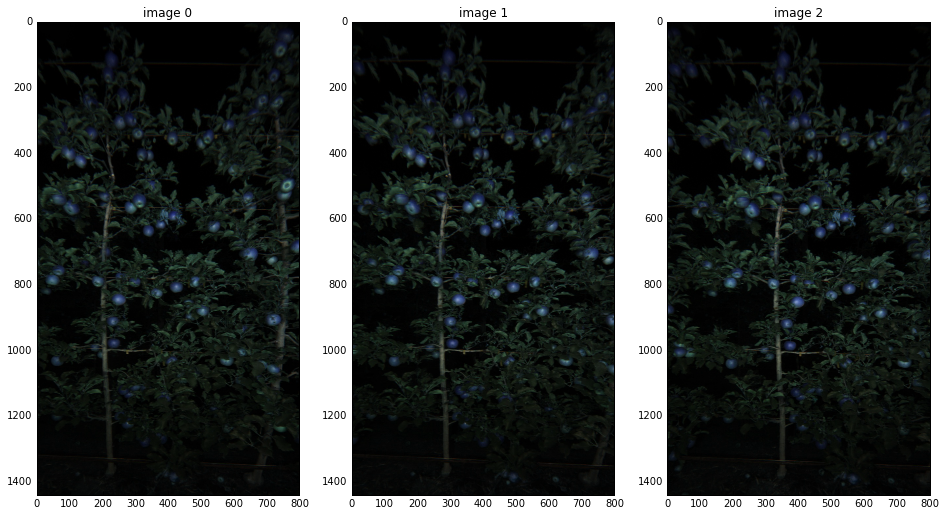

In [3]:
# Load n images
n = 3
images = []
for i in range(n):
    im = reader.read_image(i)
    im = rotate_image(im)
    im = im[:1440, 200:1000, :]
    images.append(im)

def plot_images(images):
    fig = plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, n, i + 1)
        ax.imshow(image)
        ax.set_title('image {0}'.format(i))

plot_images(images)

In [7]:
# Make a FruitTrack out of each detection
class FruitTrack(object):
    def __init__(self, blob, num_fruits=1):
        self.blob = blob
        self.num_fruits = 1
        self.kf = KalmanFilter(blob['bbox_center'])
    
    def predict(self, flow):
        pass
    
    def correct(self, blob):
        pass

def is_blob_multiple(blob):
    # For now just return false
    return False

#######################
# For now, we only care 
# about big blobs
#######################
def thresh_blobs_area(blobs, area=100):
    return blobs[blobs['area'] > area]

class Colors:
    detection_bbox = (255, 0, 0) # red
    prediction_bbox = (0, 0, 255) # blue
    optical_flow = (255, 0, 0) # red 
    prev_bbox = (255, 0, 255) # magenta

10
number of blobs in image0: 10


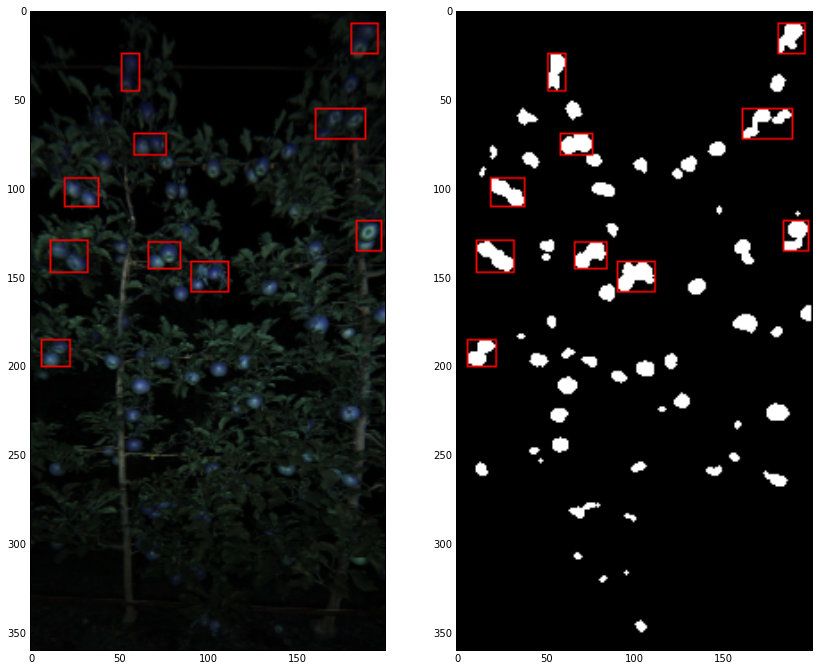

In [5]:
# We receive image0
image = images[0]

# Do detection
s, bw = detector.detect(image)
blobs, bw = region_props(bw)
blobs = thresh_blobs_area(blobs)

# We don't do optical flow because there's no previous image
prev_gray = None
gray = cv2.cvtColor(s.im_raw, cv2.COLOR_BGR2GRAY)

# initialize some new tracks and just be done
tracks = []
hsv = s.im_hsv

for blob in blobs:
    if is_blob_multiple(blob):
        bbox_region = extract_bbox(hsv, blob['bbox'])
        num_peaks = num_local_maximas(bbox_region)
    else:
        num_peaks = 1

    track = FruitTrack(blob, num_peaks)
    tracks.append(track)

print(len(tracks))

# Save the current detections
prev_gray = gray
prev_blobs = blobs

# Visualization
disp_color = np.array(s.im_raw, copy=True)
disp_bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
draw_bboxes(disp_bw, blobs['bbox'], color=Colors.detection_bbox)
draw_bboxes(disp_color, blobs['bbox'], color=Colors.detection_bbox)

# Draw all detections
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(121)
plt.imshow(disp_color)
ax = fig.add_subplot(122)
plt.imshow(disp_bw, cmap=plt.cm.gray)
print('number of blobs in image0: {0}'.format(len(blobs)))

(10, 10)
number of blobs in image0: 8


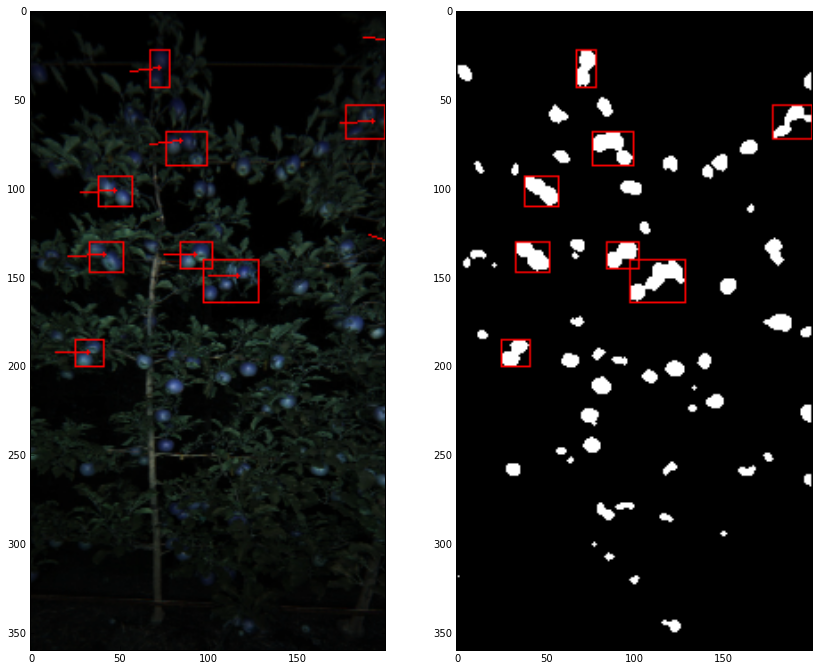

In [13]:
# We receive image1
image = images[1]

# Do detection
s, bw = detector.detect(image)
blobs, bw = region_props(bw)
blobs = thresh_blobs_area(blobs)

# Do optical flow stuff
gray = cv2.cvtColor(s.im_raw, cv2.COLOR_BGR2GRAY)
# This should be changed to bboxes that are tracked
prev_bboxes = prev_blobs['bbox']
p1, p2, st = calc_bboxes_flow(prev_gray, gray, prev_bboxes)
flow = p2 - p1

# Do some drawinngs
disp_color = np.array(s.im_raw, copy=True)
disp_bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
draw_optical_flow(disp_color, p1, p2, color=Colors.optical_flow)
draw_bboxes(disp_bw, blobs['bbox'], color=Colors.detection_bbox)
draw_bboxes(disp_color, blobs['bbox'], color=Colors.detection_bbox)

# Predict all valid tracks
print(len(tracks), len(prev_blobs))
tracks_to_predict = []

for track, 

# Draw all detections
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(121)
plt.imshow(disp_color)
ax = fig.add_subplot(122)
plt.imshow(disp_bw, cmap=plt.cm.gray)
print('number of blobs in image0: {0}'.format(len(blobs)))